In [1]:
import matplotlib.pyplot as plt
import flowkit as fk
import os
import pandas as pd
import FlowCal
import flowsom as fs
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn_extra.cluster import CLARA
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import networkx as nx
import re
from flowio import create_fcs
from scipy.stats import gmean
from fcsy import DataFrame
from fcsy import write_fcs
import matplotlib.colors as mcolors
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score, adjusted_rand_score


In [3]:
# Definir los directorios de entrada y salida
work_dir = r"C:/Users/Usuario/OneDrive/Escritorio/Palex/Muestras TFM/SAMPLES_SCAFOLD"
input_dir = work_dir + '/Muestras_cluster'
output_dir = work_dir + '/clusters_clara'
flowsom_dir = work_dir + '/clusters_flowsom'
phenograph_dir = work_dir + '/clusters_phenograph'
clara_dir = work_dir + '/clusters_clara'

In [4]:
# Función para limpiar nombres de variables
def limpiar_nombre_variable(nombre):
    # Reemplazar caracteres no deseados con un guion bajo o eliminarlos (en este caso se eliminan)
    nombre_limpio = re.sub(r'[^\w]', '_', nombre)
    return nombre_limpio

Cogemos las muestras y controles normalizados con CyCombine

In [5]:
# Cogemos los labels antes de normalizar para añadirlos al final
gated_dir = work_dir + '/Controles_muestras_gated'
archivos_fcs = [f for f in os.listdir(gated_dir) if f.endswith('.fcs')]

# Lista para almacenar las columnas OmiqFilter
omiq_filter_list = []

# Procesar cada archivo FCS
for archivo in archivos_fcs:
    archivo_fcs = os.path.join(gated_dir, archivo)
    
    # Leer el archivo FCS
    fcs_data = FlowCal.io.FCSData(archivo_fcs)
    
    # Convertir el objeto FCSData a un DataFrame de pandas
    df = pd.DataFrame(fcs_data, columns=fcs_data.channels)
    
    # Almacenar la columna OmiqFilter en la lista
    omiq_filter_list.extend(df['OmiqFilter'].tolist())


Guardamos en un df solo el gating de los controles para hacer los nodos landmark y en otro guardamos todo (controles y muestras)

In [6]:
Norm_dir = work_dir + '/Controles_muestras_normalizados'
archivo_controles = 'Controles_muestras_normalizados.csv'
archivo = os.path.join(Norm_dir, archivo_controles)

df_gating_muestras_controles = pd.read_csv(archivo)

# Añadir la columna OmiqFilter a los datos de gating
df_gating_muestras_controles['OmiqFilter'] = omiq_filter_list

In [7]:
# Cambiamos los valores de la columna OmiqFilter por los nombres reales
omiq_filter_dict = {
    0: "NA",
    1: "CM CD8",
    2: "Monocitos intermedios",
    3: "Treg",
    4: "TEMRA CD8",
    5: "NK",
    6: "Monocitos clasicos",
    7: "Monocitos no clasicos",
    8: "Non Treg",
    9: "Linfocitos B",
    10: "EM CD8",
    11: "Granulocitos",
    12: "Naive CD8"
}

df_gating_muestras_controles['OmiqFilter'] = df_gating_muestras_controles['OmiqFilter'].replace(omiq_filter_dict)

In [8]:
# Asegurarse de que la columna 'sample' es de tipo cadena (string)
df_gating_muestras_controles['sample'] = df_gating_muestras_controles['sample'].astype(str)

# Filtrar las filas donde 'sample' empieza con 'C' y no es nulo
df_gating = df_gating_muestras_controles[
    df_gating_muestras_controles['sample'].str.startswith('C')
]

In [9]:
df_gating = df_gating.drop(columns=['sample', 'batch','condition','id','label'])
# Eliminamos las filas que tienen NA en la columna OmiqFilter (no queremos un nodo NA)
df_gating = df_gating[df_gating['OmiqFilter'] != 'NA']

# No dropeamos sample porque lo usamos despues para comparar distribuciones con los clusters
df_gating_muestras_controles = df_gating_muestras_controles.drop(columns=['batch','condition','id','label'])

Calculamos el MFI de cada marcador (media o mediana) para calcular la similitud de cada par de nodos

In [10]:
# Primero vamos a coger las poblaciones obtenidas por gating
medianas = pd.DataFrame()
medias = pd.DataFrame()

# Agrupar por 'OmiqFilter' y calcular medianas, medias y medias geométricas
grouped = df_gating.groupby('OmiqFilter')

for poblacion, group in grouped:
    # Obtener el nombre de la población desde la columna 'OmiqFilter'
    variable_name = limpiar_nombre_variable(poblacion)
    
    # Excluir la columna 'OmiqFilter'
    df_gating_numeric = group.drop(columns=['OmiqFilter'])
    
    # Guardar el DataFrame en una variable global
    globals()[variable_name] = df_gating_numeric
    
    # Calcular medianas, medias y medias geométricas
    medianas[variable_name] = df_gating_numeric.median()
    medias[variable_name] = df_gating_numeric.mean()

# Transponer los DataFrames de medianas, medias y medias geométricas
medias_gating = medias.T
medianas_gating = medianas.T

In [11]:
cosine_similarities = cosine_similarity(medianas_gating)
cosine_similarities = pd.DataFrame(cosine_similarities, index=medianas_gating.index, columns=medianas_gating.index)

In [12]:
# Definir el directorio donde estan los clusters
dir_clusters = flowsom_dir

In [13]:
jerarquia = {}
# Obtener la lista de archivos de control y muestras
control_files = [f for f in os.listdir(dir_clusters) if f.startswith('C') and f.endswith('.csv')]
archivos = [f for f in os.listdir(dir_clusters) if f.endswith('.csv') and not f.startswith('C')]
# Combinar las listas de controles y muestras para un procesamiento unificado
todos_los_archivos = control_files + archivos

## Comparación muestras-controles 

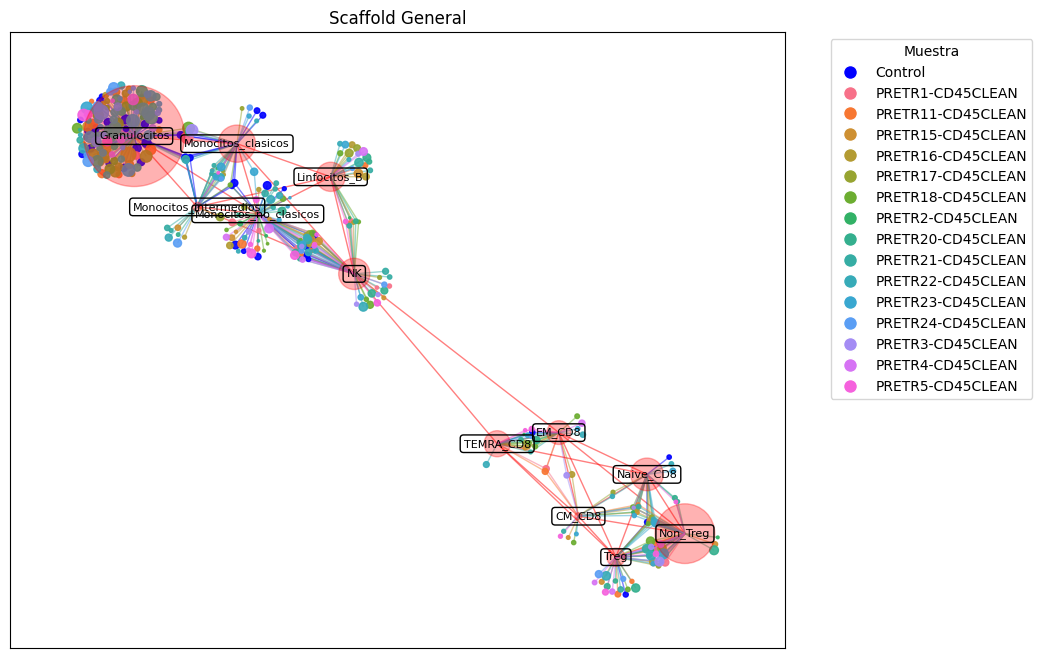

In [14]:
# Crear el grafo principal
G = nx.Graph()

# Crear una lista de nombres de nodos
nodos_gating = medianas_gating.index.tolist()

# Añadir nodos de jerarquía (solo nodos padre)
for grupo in jerarquia.keys():
    num_eventos = sum(len(globals()[limpiar_nombre_variable(hijo)]) for hijo in jerarquia[grupo] if limpiar_nombre_variable(hijo) in globals())
    size = num_eventos * 0.01  # Ajustar el factor de escala según sea necesario
    G.add_node(grupo, color='darkred', size=size)

# Crear el SCAFFOLD con los nodos de gating
for nodo in nodos_gating:
    if nodo not in jerarquia:
        num_eventos = len(globals()[limpiar_nombre_variable(nodo)])  # Calcula el número de eventos para los nodos de gating
        size = num_eventos * 0.01  # Ajustar el factor de escala según sea necesario
        G.add_node(nodo, color='red', size=size)

# Crear una matriz de similitud del coseno usando medianas_gating
valores_medianos_gating = np.vstack([medianas_gating.loc[nodo].values for nodo in medianas_gating.index])
matriz_similitud_coseno_gating = cosine_similarity(valores_medianos_gating)
np.fill_diagonal(matriz_similitud_coseno_gating, 0)
umbrales_gating = np.percentile(matriz_similitud_coseno_gating, 60, axis=0)

# Añadir aristas solo entre nodos similares basados en el umbral de similitud del coseno
for i in range(len(nodos_gating)):
    for j in range(i + 1, len(nodos_gating)):
        if matriz_similitud_coseno_gating[i, j] >= umbrales_gating[j]:
            G.add_edge(nodos_gating[i], nodos_gating[j], weight=matriz_similitud_coseno_gating[i, j]**4, color='red')

# Calcular las posiciones de los nodos de gating
pos_gating = nx.spring_layout(G, weight='weight', seed=2)

# Agrupar nodos hijos bajo nodos padres
for grupo, subnodos in jerarquia.items():
    for subnodo in subnodos:
        if subnodo in G:
            for vecino in list(G.neighbors(subnodo)):
                if vecino not in subnodos:
                    G.add_edge(grupo, vecino, weight=G[subnodo][vecino]['weight'], color='red')

# Calcular las posiciones de los nodos usando el layout Spring, fijando los nodos de gating
pos_gating_general = nx.spring_layout(G, pos=pos_gating, fixed=nodos_gating, weight='weight', seed=1)

# Crear grafos específicos para cada nodo padre
grafos_especificos = {}
for nodo_padre in jerarquia.keys():
    G_especifico = nx.Graph()
    nodos_hijos = jerarquia[nodo_padre]

    # Añadir nodos de gating hijos al grafo específico
    for nodo_hijo in nodos_hijos:
        num_eventos = len(globals()[limpiar_nombre_variable(nodo_hijo)])  # Calcula el número de eventos para los nodos de gating hijos
        size = num_eventos * 0.01  # Ajustar el factor de escala según sea necesario
        G_especifico.add_node(nodo_hijo, color='red', size=size)

    # Filtrar la matriz de similitud del coseno para los nodos hijos
    indices_hijos = [nodos_gating.index(nodo_hijo) for nodo_hijo in nodos_hijos if nodo_hijo in nodos_gating]
    submatriz_similitud_hijos = matriz_similitud_coseno_gating[np.ix_(indices_hijos, indices_hijos)]

    # Calcular los umbrales de similitud para los nodos de gating hijos
    np.fill_diagonal(submatriz_similitud_hijos, 0)
    umbrales_hijos = np.percentile(submatriz_similitud_hijos, 70, axis=0)

    # Añadir aristas solo entre nodos similares basados en el umbral de similitud del coseno
    for i in range(len(nodos_hijos)):
        for j in range(i + 1, len(nodos_hijos)):
            if submatriz_similitud_hijos[i, j] >= umbrales_hijos[j]:
                G_especifico.add_edge(nodos_hijos[i], nodos_hijos[j], weight=submatriz_similitud_hijos[i, j]**4, color='red')

    # Calcular las posiciones de los nodos de gating hijos
    pos_hijos = nx.spring_layout(G_especifico, weight='weight', seed=1)

    # Guardar el grafo específico
    grafos_especificos[nodo_padre] = (G_especifico, pos_hijos)

# Preparar colores para las muestras
num_archivos = len(archivos) + 1  # Añadimos 1 para el grupo de controles
colores = sns.color_palette('husl', num_archivos)

# Asignar un color específico al control (azul)
idx_control = num_archivos - 1  # Índice del color para controles
colores[idx_control] = (0, 0, 1)  # Azul para el control

leyenda = {}
tamanos_nodos = {}
nodos_cluster_todos = []

clusters_unidos_a_gating = {nodo_gating: [] for nodo_gating in nodos_gating + list(jerarquia.keys())}

# Procesar los controles y combinarlos
df_control = pd.DataFrame()
for control_file in control_files:
    archivo_path = os.path.join(dir_clusters, control_file)
    df_temp = pd.read_csv(archivo_path)
    df_control = pd.concat([df_control, df_temp], ignore_index=True)

# Eliminar columnas no necesarias
columnas_a_eliminar = ['condition', 'batch', 'sample', 'id', 'label']
df_control = df_control.drop(columns=[col for col in columnas_a_eliminar if col in df_control.columns])

# Procesar los clusters de controles
medianas_control = df_control.groupby('cluster').median()
medianas_control = medianas_control.rename(index=lambda x: f"C_{x}_Control")
medianas_gating_control = pd.concat([medianas_gating, medianas_control], axis=0)

nodos_clusters_control = medianas_control.index.tolist()
nodos = nodos_gating + nodos_clusters_control
nodos_cluster_todos.append(nodos_clusters_control)

nodos_hijos = [nodo for subnodos in jerarquia.values() for nodo in subnodos]
nodos_padre = list(jerarquia.keys())
medianas_sin_padre = medianas_gating_control.drop(nodos_padre, errors='ignore')

# Crear matriz de similitud para controles
valores_medianos = np.vstack([medianas_sin_padre.loc[nodo].values for nodo in medianas_sin_padre.index])
matriz_similitud_coseno = cosine_similarity(valores_medianos)
df_similitud_coseno = pd.DataFrame(matriz_similitud_coseno, index=medianas_sin_padre.index, columns=medianas_sin_padre.index)

submatriz_clusters_gating = matriz_similitud_coseno[len(nodos_gating):, :len(nodos_gating)]
umbrales_clusters_gating = 0.9

# Añadir nodos de clusters de control al grafo
for nodo in nodos_clusters_control:
    cluster_num = int(nodo.split('_')[1])
    num_eventos = len(df_control[df_control['cluster'] == cluster_num])
    tamanos_nodos[nodo] = (num_eventos / 10) * 0.01  # Dividir tamaño entre 10
    G.add_node(nodo, color=colores[idx_control], size=tamanos_nodos[nodo])

leyenda['Control'] = colores[idx_control]

# Añadir aristas entre clusters de control y nodos de gating
for i in range(len(nodos_clusters_control)):
    for j in range(len(nodos_gating)):
        nodo_gating = nodos_gating[j]
        if nodo_gating in jerarquia:
            for subnodo in jerarquia[nodo_gating]:
                if subnodo in df_similitud_coseno.index:
                    idx_cluster = nodos.index(nodos_clusters_control[i])
                    idx_subnodo = nodos.index(subnodo)
                    if matriz_similitud_coseno[idx_cluster, idx_subnodo] >= umbrales_clusters_gating:
                        G.add_edge(nodos_clusters_control[i], nodo_gating, weight=matriz_similitud_coseno[idx_cluster, idx_subnodo]**4, color=colores[idx_control])
                        clusters_unidos_a_gating[nodo_gating].append(nodos_clusters_control[i])
        else:
            if nodo_gating in df_similitud_coseno.index:
                idx_cluster = nodos.index(nodos_clusters_control[i])
                idx_gating = nodos.index(nodo_gating)
                if matriz_similitud_coseno[idx_cluster, idx_gating] >= umbrales_clusters_gating:
                    G.add_edge(nodos_clusters_control[i], nodo_gating, weight=matriz_similitud_coseno[idx_cluster, idx_gating]**4, color=colores[idx_control])
                    clusters_unidos_a_gating[nodo_gating].append(nodos_clusters_control[i])

# Conectar nodos padres a clusters de control si es necesario
for grupo, subnodos in jerarquia.items():
    for subnodo in subnodos:
        if subnodo in G:
            for nodo_cluster in nodos_clusters_control:
                if G.has_edge(nodo_cluster, subnodo):
                    G.add_edge(grupo, nodo_cluster, weight=G[subnodo][nodo_cluster]['weight']**4, color=colores[idx_control])
                    clusters_unidos_a_gating[grupo].append(nodo_cluster)

# Calcular posiciones de los nodos usando el layout Spring, fijando los nodos de gating
pos = nx.spring_layout(G, pos=pos_gating_general, fixed=list(pos_gating_general.keys()), weight='weight', k=0.02 / np.mean(matriz_similitud_coseno), seed=1)

# Actualizar grafos específicos con datos de control
for nodo_padre in nodos_padre:
    if nodo_padre in grafos_especificos:
        G_especifico, pos_hijos = grafos_especificos[nodo_padre]

        nodos_hijos_padre = [nodo for nodo in nodos_hijos if nodo in pos_hijos]

        # Añadir clusters de control conectados a los nodos hijos
        for nodo_cluster in nodos_clusters_control:
            for nodo_hijo in nodos_hijos_padre:
                if nodo_hijo in df_similitud_coseno.index and nodo_cluster in df_similitud_coseno.index:
                    idx_cluster = nodos.index(nodo_cluster)
                    idx_hijo = nodos.index(nodo_hijo)
                    if matriz_similitud_coseno[idx_cluster, idx_hijo] >= umbrales_clusters_gating:
                        G_especifico.add_node(nodo_cluster, color=colores[idx_control], size=tamanos_nodos[nodo_cluster])
                        G_especifico.add_edge(nodo_cluster, nodo_hijo, weight=matriz_similitud_coseno[idx_cluster, idx_hijo]**4, color=colores[idx_control])
                        clusters_unidos_a_gating[nodo_hijo].append(nodo_cluster)

        # Calcular posiciones de los nodos específicos
        pos_especifico = nx.spring_layout(G_especifico, pos=pos_hijos, fixed=nodos_hijos_padre, weight='weight', k=0.02 / np.mean(matriz_similitud_coseno), seed=1)
        pos_clusters = nx.spring_layout(G_especifico, pos=pos_especifico, fixed=nodos_hijos_padre, weight='weight', k=0.02 / np.mean(matriz_similitud_coseno), seed=1)

        # Actualizar posiciones
        pos_especifico.update(pos_clusters)
        grafos_especificos[nodo_padre] = (G_especifico, pos_especifico)

# Procesar las muestras
for idx, archivo in enumerate(archivos):
    archivo_path = os.path.join(dir_clusters, archivo)
    df_cluster = pd.read_csv(archivo_path)

    # Eliminar las columnas no necesarias
    columnas_a_eliminar = ['condition', 'batch', 'sample', 'id', 'label']
    df_cluster = df_cluster.drop(columns=[col for col in columnas_a_eliminar if col in df_cluster.columns])

    medianas_cluster = df_cluster.groupby('cluster').median()
    medianas_cluster = medianas_cluster.rename(index=lambda x: f"C_{x}_{archivo}")
    medianas_todo = pd.concat([medianas_gating, medianas_cluster], axis=0)

    nodos_clusters = medianas_cluster.index.tolist()
    nodos = nodos_gating + nodos_clusters
    nodos_cluster_todos.append(nodos_clusters)

    medianas_sin_padre = medianas_todo.drop(nodos_padre, errors='ignore')

    # Crear una matriz de similitud del coseno
    valores_medianos = np.vstack([medianas_sin_padre.loc[nodo].values for nodo in medianas_sin_padre.index])
    matriz_similitud_coseno = cosine_similarity(valores_medianos)
    df_similitud_coseno = pd.DataFrame(matriz_similitud_coseno, index=medianas_sin_padre.index, columns=medianas_sin_padre.index)

    submatriz_clusters_gating = matriz_similitud_coseno[len(nodos_gating):, :len(nodos_gating)]
    umbrales_clusters_gating = 0.9

    # Añadir nodos de clusters al grafo
    for nodo in nodos_clusters:
        cluster_num = int(nodo.split('_')[1])
        num_eventos = len(df_cluster[df_cluster['cluster'] == cluster_num])
        tamanos_nodos[nodo] = num_eventos * 0.01  # Ajustar el factor de escala según sea necesario
        G.add_node(nodo, color=colores[idx], size=tamanos_nodos[nodo])

    # Añadir entrada a la leyenda
    nombre_muestra = archivo.split('_clusters.csv')[0]
    leyenda[nombre_muestra] = colores[idx]

    # Añadir aristas entre clusters y nodos de gating
    for i in range(len(nodos_clusters)):
        for j in range(len(nodos_gating)):
            nodo_gating = nodos_gating[j]
            if nodo_gating in jerarquia:
                for subnodo in jerarquia[nodo_gating]:
                    if subnodo in df_similitud_coseno.index:
                        idx_cluster = nodos.index(nodos_clusters[i])
                        idx_subnodo = nodos.index(subnodo)
                        if matriz_similitud_coseno[idx_cluster, idx_subnodo] >= umbrales_clusters_gating:
                            G.add_edge(nodos_clusters[i], nodo_gating, weight=matriz_similitud_coseno[idx_cluster, idx_subnodo]**4, color=colores[idx])
                            clusters_unidos_a_gating[nodo_gating].append(nodos_clusters[i])
            else:
                if nodo_gating in df_similitud_coseno.index:
                    idx_cluster = nodos.index(nodos_clusters[i])
                    idx_gating = nodos.index(nodo_gating)
                    if matriz_similitud_coseno[idx_cluster, idx_gating] >= umbrales_clusters_gating:
                        G.add_edge(nodos_clusters[i], nodo_gating, weight=matriz_similitud_coseno[idx_cluster, idx_gating]**4, color=colores[idx])
                        clusters_unidos_a_gating[nodo_gating].append(nodos_clusters[i])

    # Conectar nodos padres a clusters si es necesario
    for grupo, subnodos in jerarquia.items():
        for subnodo in subnodos:
            if subnodo in G:
                for nodo_cluster in nodos_clusters:
                    if G.has_edge(nodo_cluster, subnodo):
                        G.add_edge(grupo, nodo_cluster, weight=G[subnodo][nodo_cluster]['weight']**4, color=colores[idx])
                        clusters_unidos_a_gating[grupo].append(nodo_cluster)

    # Calcular posiciones de los nodos usando el layout Spring, fijando los nodos de gating
    pos = nx.spring_layout(G, pos=pos_gating_general, fixed=list(pos_gating_general.keys()), weight='weight', k=0.02 / np.mean(matriz_similitud_coseno), seed=1)

    for nodo_padre in nodos_padre:
        if nodo_padre in grafos_especificos:
            G_especifico, pos_hijos = grafos_especificos[nodo_padre]

            nodos_hijos_padre = [nodo for nodo in nodos_hijos if nodo in pos_hijos]

            # Añadir clusters conectados a los nodos hijos
            for nodo_cluster in nodos_clusters:
                for nodo_hijo in nodos_hijos_padre:
                    if nodo_hijo in df_similitud_coseno.index and nodo_cluster in df_similitud_coseno.index:
                        idx_cluster = nodos.index(nodo_cluster)
                        idx_hijo = nodos.index(nodo_hijo)
                        if matriz_similitud_coseno[idx_cluster, idx_hijo] >= umbrales_clusters_gating:
                            G_especifico.add_node(nodo_cluster, color=colores[idx], size=tamanos_nodos[nodo_cluster])
                            G_especifico.add_edge(nodo_cluster, nodo_hijo, weight=matriz_similitud_coseno[idx_cluster, idx_hijo]**4, color=colores[idx])
                            clusters_unidos_a_gating[nodo_hijo].append(nodo_cluster)

            # Calcular posiciones de los nodos específicos
            pos_especifico = nx.spring_layout(G_especifico, pos=pos_hijos, fixed=nodos_hijos_padre, weight='weight', k=0.02 / np.mean(matriz_similitud_coseno), seed=1)
            pos_clusters = nx.spring_layout(G_especifico, pos=pos_especifico, fixed=nodos_hijos_padre, weight='weight', k=0.02 / np.mean(matriz_similitud_coseno), seed=1)

            # Actualizar posiciones
            pos_especifico.update(pos_clusters)
            grafos_especificos[nodo_padre] = (G_especifico, pos_especifico)

# Eliminar nodos hijos de jerarquía para limpiar el grafo principal
for grupo, subnodos in jerarquia.items():
    for subnodo in subnodos:
        if subnodo in G:
            G.remove_node(subnodo)

# Recalcular posiciones del grafo principal sin nodos hijos
pos_gating_general = nx.spring_layout(G, pos=pos_gating, fixed=nodos_gating, weight='weight', seed=1)

# Filtrar solo nodos conectados (clusters + gating + padres)
nodos_clusters_conexos = [nodo for sublist in nodos_cluster_todos for nodo in sublist if G.degree(nodo) > 0]

# Listas de nodos con posiciones
nodos_gating_con_pos = [nodo for nodo in nodos_gating if nodo in pos_gating_general]
nodos_padre_con_pos = [nodo for nodo in nodos_padre if nodo in pos_gating_general]
nodos_general = nodos_clusters_conexos + nodos_gating_con_pos + nodos_padre_con_pos

# Dibujar el grafo principal
plt.figure(figsize=(10, 8))
# Dibujar nodos de clusters
nx.draw_networkx_nodes(G, pos_gating_general, nodelist=nodos_clusters_conexos, node_color=[G.nodes[n]['color'] for n in nodos_clusters_conexos], node_size=[G.nodes[n]['size'] for n in nodos_clusters_conexos], alpha=0.9)
# Dibujar nodos de gating
nx.draw_networkx_nodes(G, pos_gating_general, nodelist=nodos_gating_con_pos, node_color=[G.nodes[n]['color'] for n in nodos_gating_con_pos], node_size=[G.nodes[n]['size'] for n in nodos_gating_con_pos], alpha=0.3)
# Dibujar nodos padres
nx.draw_networkx_nodes(G, pos_gating_general, nodelist=nodos_padre_con_pos, node_color=[G.nodes[n]['color'] for n in nodos_padre_con_pos], node_size=[G.nodes[n]['size'] for n in nodos_padre_con_pos], alpha=0.3)
# Dibujar aristas
nx.draw_networkx_edges(G, pos_gating_general, edge_color=[G[u][v]['color'] for u, v in G.edges()], width=1.0, alpha=0.5)
# Añadir etiquetas solo a los nodos de gating y nodos padres
labels = {nodo: nodo for nodo in nodos_gating_con_pos + nodos_padre_con_pos}
nx.draw_networkx_labels(G, pos_gating_general, labels=labels, font_size=8, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
plt.title('Scaffold General')
# Añadir leyenda
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=nombre) for nombre, color in leyenda.items()]
plt.legend(handles=handles, title="Muestra", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Dibujar grafos específicos
for nodo_padre, (G_especifico, pos_especifico) in grafos_especificos.items():
    # Obtener nodos hijos y nodos de clusters con posiciones
    nodos_hijos_con_pos = [nodo for nodo in jerarquia[nodo_padre] if nodo in pos_especifico]
    nodos_clusters_con_pos = [nodo for nodo in G_especifico.nodes if nodo not in jerarquia[nodo_padre] and nodo in pos_especifico]

    plt.figure(figsize=(10, 8))
    # Dibujar nodos de clusters
    nx.draw_networkx_nodes(G_especifico, pos_especifico, nodelist=nodos_clusters_con_pos, node_color=[G_especifico.nodes[n]['color'] for n in nodos_clusters_con_pos], node_size=[G_especifico.nodes[n]['size'] for n in nodos_clusters_con_pos], alpha=0.9)
    # Dibujar nodos de gating
    nx.draw_networkx_nodes(G_especifico, pos_especifico, nodelist=nodos_hijos_con_pos, node_color=[G_especifico.nodes[n]['color'] for n in nodos_hijos_con_pos], node_size=[G_especifico.nodes[n]['size'] for n in nodos_hijos_con_pos], alpha=0.3)
    # Dibujar aristas
    nx.draw_networkx_edges(G_especifico, pos_especifico, edge_color=[G_especifico[u][v]['color'] for u, v in G_especifico.edges()], width=1.0, alpha=0.5)
    # Añadir etiquetas solo a los nodos de gating
    labels = {nodo: nodo for nodo in nodos_hijos_con_pos}
    nx.draw_networkx_labels(G_especifico, pos_especifico, labels=labels, font_size=8, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
    plt.title(f'Scaffold específico para {nodo_padre}')
    plt.show()

Calculo de los porcentajes de poblaciones en cada muestra

In [ ]:
archivos_muestras = archivos

# Variables para almacenar los porcentajes y asignaciones
cluster_assignments = {}
porcentajes_poblaciones = {}

# Procesar los controles individualmente
for control_file in control_files:
    archivo_path = os.path.join(dir_clusters, control_file)
    df_control = pd.read_csv(archivo_path)
    
    # Eliminar las columnas no necesarias
    columnas_a_eliminar = ['condition', 'batch', 'sample', 'id', 'label']
    df_control = df_control.drop(columns=[col for col in columnas_a_eliminar if col in df_control.columns])
    
    # Renombrar los clusters para identificar el control
    medianas_cluster_control = df_control.groupby('cluster').median()
    medianas_cluster_control = medianas_cluster_control.rename(index=lambda x: f"C_{x}_{control_file}")
    medianas_todo_control = pd.concat([medianas_gating, medianas_cluster_control], axis=0)
    
    nodos_clusters_control = medianas_cluster_control.index.tolist()
    nodos = nodos_gating + nodos_clusters_control
    
    nodos_hijos = [nodo for subnodos in jerarquia.values() for nodo in subnodos]
    nodos_padre = list(jerarquia.keys())
    medianas_sin_padre_control = medianas_todo_control.drop(nodos_padre, errors='ignore')
    
    # Crear matriz de similitud para este control
    valores_medianos_control = np.vstack([medianas_sin_padre_control.loc[nodo].values for nodo in medianas_sin_padre_control.index])
    matriz_similitud_coseno_control = cosine_similarity(valores_medianos_control)
    df_similitud_coseno_control = pd.DataFrame(
        matriz_similitud_coseno_control,
        index=medianas_sin_padre_control.index,
        columns=medianas_sin_padre_control.index
    )
    
    umbral_clusters_gating = 0.9
    
    # Inicializar diccionarios para este control
    cluster_assignments_control = {}
    node_clusters_control = {nodo: [] for nodo in nodos_gating + nodos_padre + nodos_hijos}
    
    # Asignar clusters de control a nodos de gating, padres o hijos
    for nodo_cluster in nodos_clusters_control:
        max_similitud = 0
        nodo_asignado = None
        for nodo_ref in nodos_gating + nodos_hijos:
            if nodo_ref in medianas_sin_padre_control.index:
                similitud = df_similitud_coseno_control.loc[nodo_cluster, nodo_ref]
                if similitud >= umbral_clusters_gating and similitud > max_similitud:
                    max_similitud = similitud
                    nodo_asignado = nodo_ref
    
        if nodo_asignado:
            cluster_assignments_control[nodo_cluster] = nodo_asignado
            node_clusters_control[nodo_asignado].append(nodo_cluster)
        else:
            cluster_assignments_control[nodo_cluster] = None
    
    # Calcular porcentajes para este control individual
    total_celulas_control = len(df_control)
    porcentajes_poblaciones[control_file] = {}
    
    for nodo in nodos_gating + nodos_padre + nodos_hijos:
        clusters_asignados = node_clusters_control.get(nodo, [])
        if clusters_asignados:
            cluster_nums = [int(c.split('_')[1]) for c in clusters_asignados]
            celulas_asociadas = df_control[df_control['cluster'].isin(cluster_nums)].shape[0]
            porcentaje = (celulas_asociadas / total_celulas_control) * 100
            porcentajes_poblaciones[control_file][nodo] = porcentaje
    
    # Calcular porcentaje de clusters no asignados
    clusters_asignados = set([cluster for cluster, nodo in cluster_assignments_control.items() if nodo is not None])
    clusters_no_asignados = set(nodos_clusters_control) - clusters_asignados
    if clusters_no_asignados:
        cluster_nums_no_asignados = [int(c.split('_')[1]) for c in clusters_no_asignados]
        celulas_no_conectadas = df_control[df_control['cluster'].isin(cluster_nums_no_asignados)].shape[0]
        porcentaje_no_conectados = (celulas_no_conectadas / total_celulas_control) * 100
        porcentajes_poblaciones[control_file]['Unassigned'] = porcentaje_no_conectados
    else:
        porcentajes_poblaciones[control_file]['Unassigned'] = 0

# Procesar muestras individuales
for archivo in archivos_muestras:
    archivo_path = os.path.join(dir_clusters, archivo)
    df_cluster = pd.read_csv(archivo_path)
    
    # Eliminar las columnas no necesarias
    columnas_a_eliminar = ['condition', 'batch', 'sample', 'id', 'label']
    df_cluster = df_cluster.drop(columns=[col for col in columnas_a_eliminar if col in df_cluster.columns])
    
    # Renombrar los clusters para identificar el archivo
    medianas_cluster = df_cluster.groupby('cluster').median()
    medianas_cluster = medianas_cluster.rename(index=lambda x: f"C_{x}_{archivo}")
    medianas_todo = pd.concat([medianas_gating, medianas_cluster], axis=0)
    
    nodos_clusters = medianas_cluster.index.tolist()
    nodos = nodos_gating + nodos_clusters
    
    medianas_sin_padre = medianas_todo.drop(nodos_padre, errors='ignore')
    
    # Crear una matriz de similitud del coseno
    valores_medianos = np.vstack([medianas_sin_padre.loc[nodo].values for nodo in medianas_sin_padre.index])
    matriz_similitud_coseno = cosine_similarity(valores_medianos)
    df_similitud_coseno = pd.DataFrame(
        matriz_similitud_coseno,
        index=medianas_sin_padre.index,
        columns=medianas_sin_padre.index
    )
    
    umbral_clusters_gating = 0.9
    
    # Inicializar diccionarios para esta muestra
    cluster_assignments_muestra = {}
    node_clusters_muestra = {nodo: [] for nodo in nodos_gating + nodos_padre + nodos_hijos}
    
    # Asignar clusters a nodos de gating, padres o hijos
    for nodo_cluster in nodos_clusters:
        max_similitud = 0
        nodo_asignado = None
        for nodo_ref in nodos_gating + nodos_hijos:
            if nodo_ref in medianas_sin_padre.index:
                similitud = df_similitud_coseno.loc[nodo_cluster, nodo_ref]
                if similitud >= umbral_clusters_gating and similitud > max_similitud:
                    max_similitud = similitud
                    nodo_asignado = nodo_ref
    
        if nodo_asignado:
            cluster_assignments_muestra[nodo_cluster] = nodo_asignado
            node_clusters_muestra[nodo_asignado].append(nodo_cluster)
        else:
            cluster_assignments_muestra[nodo_cluster] = None
    
    # Calcular porcentajes
    total_celulas = len(df_cluster)
    porcentajes_poblaciones[archivo] = {}
    
    for nodo in nodos_gating + nodos_padre + nodos_hijos:
        clusters_asignados = node_clusters_muestra.get(nodo, [])
        if clusters_asignados:
            cluster_nums = [int(c.split('_')[1]) for c in clusters_asignados]
            celulas_asociadas = df_cluster[df_cluster['cluster'].isin(cluster_nums)].shape[0]
            porcentaje = (celulas_asociadas / total_celulas) * 100
            porcentajes_poblaciones[archivo][nodo] = porcentaje
    
    # Calcular porcentaje de clusters no asignados
    clusters_asignados = set([cluster for cluster, nodo in cluster_assignments_muestra.items() if nodo is not None])
    clusters_no_asignados = set(nodos_clusters) - clusters_asignados
    if clusters_no_asignados:
        cluster_nums_no_asignados = [int(c.split('_')[1]) for c in clusters_no_asignados]
        celulas_no_conectadas = df_cluster[df_cluster['cluster'].isin(cluster_nums_no_asignados)].shape[0]
        porcentaje_no_conectados = (celulas_no_conectadas / total_celulas) * 100
        porcentajes_poblaciones[archivo]['Unassigned'] = porcentaje_no_conectados
    else:
        porcentajes_poblaciones[archivo]['Unassigned'] = 0

# Crear el DataFrame de porcentajes
df_porcentajes = pd.DataFrame(porcentajes_poblaciones).T.fillna(0)

# Reordenar las columnas para que 'Unassigned' sea la última
if 'Unassigned' in df_porcentajes.columns:
    cols = [col for col in df_porcentajes.columns if col != 'Unassigned'] + ['Unassigned']
    df_porcentajes = df_porcentajes[cols]

Ahora definimos la jerarquía que queramos para aplicarla a posteriori

In [ ]:
# Definir la jerarquía de nodos
jerarquia = {
    'Linfocitos': ['Linfocitos_B', 'Treg', 'Non_Treg', 'Naive_CD8', 'EM_CD8', 'CM_CD8', 'TEMRA_CD8', 'NK'],
    'Monocitos': ['Monocitos_no_clasicos', 'Monocitos_intermedios', 'Monocitos_clasicos']
}

In [ ]:
# Aplicar la jerarquía al DataFrame de porcentajes para df_nuevo
nodos_hijos = [hijo for hijos in jerarquia.values() for hijo in hijos]
nodos_padre = list(jerarquia.keys())
nodos_no_jerarquia = [col for col in df_porcentajes.columns if col not in nodos_hijos and col not in nodos_padre]

df_nuevo = pd.DataFrame(index=df_porcentajes.index)

# Calcular los porcentajes de los nodos padre sumando los porcentajes de sus hijos
for padre, hijos in jerarquia.items():
    hijos_presentes = [hijo for hijo in hijos if hijo in df_porcentajes.columns]
    if hijos_presentes:
        df_nuevo[padre] = df_porcentajes[hijos_presentes].sum(axis=1)

# Añadir las columnas de los nodos que no están en la jerarquía
df_nuevo = pd.concat([df_nuevo, df_porcentajes[nodos_no_jerarquia]], axis=1)

# Asegurar que 'Unassigned' sea la última columna
if 'Unassigned' in df_nuevo.columns:
    cols = [col for col in df_nuevo.columns if col != 'Unassigned'] + ['Unassigned']
    df_nuevo = df_nuevo[cols]

# Crear un nuevo DataFrame para controles individuales
df_controles_individuales = df_nuevo[df_nuevo.index.str.startswith('C')]
df_muestras = df_nuevo[~df_nuevo.index.str.startswith('C')]

# Verificar las sumas de porcentajes por muestra
df_nuevo['Suma'] = df_nuevo.sum(axis=1)


# Asegurarse de que los índices son de tipo cadena (string)
df_nuevo.index = df_nuevo.index.astype(str)

# Eliminar todo lo que va después del primer guion bajo en los nombres de los índices
df_nuevo.index = df_nuevo.index.str.split('_').str[0]

In [ ]:
# Creamos un df que contenga los controles en una sola linea para una mejor comparacion

# Separar las muestras y los controles individuales
df_muestras = df_nuevo[~df_nuevo.index.str.startswith('C')]
df_controles = df_nuevo[df_nuevo.index.str.startswith('C')]

# Calcular la media de los controles para agregarlos en una sola línea
control_aggregado = df_controles.mean()
control_aggregado.name = 'Control'

# Crear un nuevo DataFrame que combine las muestras y el control agregado
df_controles_agregados = pd.concat([df_muestras, control_aggregado.to_frame().T])

Comparamos los controles con las muestras para ver donde hay grandes diferencias

In [ ]:
# Visualizar las diferencias para una población específica
poblacion_interes = 'Unassigned'  # Reemplaza con la población que desees

plt.figure(figsize=(12, 6))

# Datos de control agregado y muestras para la población de interés
datos_control = df_controles_agregados.loc['Control', poblacion_interes]
datos_muestras = df_controles_agregados.drop('Control').loc[:, poblacion_interes]

# Número total de muestras
num_samples = len(df_controles_agregados) - 1  # Restamos 1 para excluir la línea 'Control'

# Graficar datos de control en posición 0
sns.boxplot(x=[0] * len(df_controles_individuales), y=df_controles_individuales[poblacion_interes], color='lightblue')
sns.stripplot(x=[0] * len(df_controles_individuales), y=df_controles_individuales[poblacion_interes], color='blue', jitter=True)

# Graficar datos de muestras individuales en posiciones 1 a n
sns.scatterplot(x=list(range(1, num_samples + 1)), y=datos_muestras.values, color='red', label='Muestras')

# Definir las etiquetas del eje x
# 'Control' está en la posición 0, las muestras en 1 a n
# Procesar los nombres de las muestras para mostrar solo la parte antes del primer guion
sample_labels_full = df_controles_agregados.drop('Control').index.tolist()
sample_labels_trimmed = [label.split('-')[0] if '-' in label else label for label in sample_labels_full]

# Crear las etiquetas incluyendo 'Control'
etiquetas_x = ['Control'] + sample_labels_trimmed

# Asignar las etiquetas al eje x
plt.xticks(ticks=list(range(0, num_samples + 1)), labels=etiquetas_x, rotation=70)

plt.ylabel('Porcentaje')
plt.title(f'Comparación de {poblacion_interes} entre Controles y Muestras')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Poblaciones a analizar
poblaciones = ['Linfocitos', 'Monocitos', 'Granulocitos', 'Unassigned']

# Crear DataFrames para visualización
df_viz_controles = df_controles_individuales.reset_index().melt(
    id_vars='index',
    value_vars=poblaciones,
    var_name='Población',
    value_name='Porcentaje'
)
df_viz_controles.rename(columns={'index': 'Muestra'}, inplace=True)
df_viz_controles['Grupo'] = 'Control'

df_viz_muestras = df_muestras.reset_index().melt(
    id_vars='index',
    value_vars=poblaciones,
    var_name='Población',
    value_name='Porcentaje'
)
df_viz_muestras.rename(columns={'index': 'Muestra'}, inplace=True)
df_viz_muestras['Grupo'] = 'Muestra'

# Combinar los DataFrames
df_viz = pd.concat([df_viz_controles, df_viz_muestras], ignore_index=True)

# Gráfico de barras con puntos individuales
plt.figure(figsize=(12, 6))

# Usar np.mean como estimador
sns.barplot(
    data=df_viz,
    x='Población',
    y='Porcentaje',
    hue='Grupo',
    estimator=np.mean,
    errorbar=None,
    palette='Set2'
)

# Añadir puntos individuales
sns.stripplot(
    data=df_viz,
    x='Población',
    y='Porcentaje',
    hue='Grupo',
    dodge=True,
    jitter=True,
    alpha=0.5,
    color='black'
)

plt.xticks(rotation=45)
plt.title('Comparación de Poblaciones Celulares entre Controles y Muestras')
plt.ylabel('Porcentaje')

# Eliminar leyendas duplicadas
handles, labels = plt.gca().get_legend_handles_labels()
nuevos_handles = []
nuevas_labels = []
for h, l in zip(handles, labels):
    if l not in nuevas_labels:
        nuevos_handles.append(h)
        nuevas_labels.append(l)
plt.legend(nuevos_handles, nuevas_labels, title='Grupo')

plt.tight_layout()
plt.show()